## Detekcia falošných správ zameraných na tému Covid-19 - ponechanie rozdelenia cieľového atribútu, vymazané stop slová

#### Ako prvé načítame všetký potrebné knižnice.

In [1]:
#načítanie potrebných knižníc
import pandas as pd
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from bs4 import BeautifulSoup
import re
import nltk
import gensim
from gensim.models import Word2Vec
import os
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model, load_model
from keras.layers import Input, concatenate, Activation, Dense, Dropout, Flatten, LSTM, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score

from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
import collections

Using TensorFlow backend.


#### Načítame dátovu množinu, ktorú sme získali z aplikácie POSTMAN. Články máme uložené v dvoch súboroch.

In [2]:
#načítanie dátovej množiny
korona=pd.read_csv("detekcia_Covid19.csv")

#### Vymažeme potenciálne duplicitné hodnoty na základe atribútu, ktorý uchováva url adresu článku.

In [4]:
#vymazanie duplicitných hodnôt
korona=korona.drop_duplicates(subset='url', keep="last")

#### Nižšie je vypísaná ukážka dátovej množiny, kde môžeme vidieť, že množina obsahuje atribúty ako name, url, body, perex. Atribút name nám hovorí o názve autora článku, url atribút hovorí  o url adrese odkazujúcej sa na článok, body je telo samotného článku, podľa ktorého sme správy detekovali, perex je úvodná, hrubo vytlačená časť článku tzv. uvedenie.

In [5]:
#ukážka dátovej množiny
korona.head()

,name,url,body,perex,published
187,redaktor maria miz,https://www.hlavnespravy.sk/ceska-vlada-predlz...,Praha 9. apríla 2020 (SITA/HSP/Foto:SITA/AP-Ef...,<p>Praha 9. apríla 2020 (SITA/HSP/Foto:SITA/AP...,2020-04-09T17:40:29.000000+0200
189,ta3.com,https://www.ta3.com/clanok/1190300/pracuju-aj-...,NaN,"Veterinári, ošetrovatelia zvierat aj zamestnan...",2020-08-17T10:37:25.000000+0200
190,hnonline.sk,https://finweb.hnonline.sk/financie-a-burzy/21...,NaN,Trhy sú naďalej znepokojené ekonomickými dôsle...,2020-03-11T19:37:00.000000+0100
191,ta3.com,https://www.ta3.com/clanok/1178311/taliansko-z...,NaN,V Taliansku zatvoria v súvislosti s rýchlym ší...,2020-03-11T22:19:40.000000+0100
194,Martina Max,https://www.hlavnespravy.sk/naozaj-koronavirus...,Bratislava 12. apríla 2020 (HSP/Foto:Pixabay)\...,<p>Bratislava 12. apríla 2020 (HSP/Foto:Pixaba...,2020-04-12T12:31:47.000000+0200


#### Nižšie je zoznam všetkých autorov článkov s početnošťami článkov od jednotlivých autorov.

In [6]:
#výpis autorov a počet ich článkov
korona.name.value_counts()

ta3.com                      1964
redaktor janka papcunova     1691
Martina Max                  1569
redaktor maria dutkova       1539
redaktor maria miz           1528
aktuality.sk                 1522
hnonline.sk                  1364
tomas zajaros                1172
sme.sk                        476
zemavek.sk                    313
hlavnespravy.sk               310
redaktor jaroslav             234
maria palastova               202
slobodnyvysielac.sk           176
Redakcia                       59
redakcia                       29
redaktor ivana                 21
admin                          19
redaktor ivana pl              10
redaktor zuzana                10
lenzena                         7
redaktor renata karbanova       5
Martin Kočiš                    2
bajecnezeny.sk                  2
Verrny                          1
::prop                          1
Name: name, dtype: int64

#### Z dátovej množiny vymažeme zdroj blog.sme, pretože je pre náš výber článkov, ktoré sa zameriavajú na politiku a ekonomiku nerelevantný. Nižšie tiež nastavíme autorom jednotlivých článkov dôverihodnosť a to 0 - pravdivé články, 1 - nepravdivé. K zisťovaniu dôveryhodnosti daných článkov nám z časti pomohla stránka konšpirátori.sk, ale taktiež sme vykonali aj manuálne priradenie relevantnosti. Z každého zdroja, odkiaľ články pochádzali, sme si vybrali náhodne zopár článkov, ktoré sme celé prečítali a priradili následne všetkým článkom z daného zdroja relevantnosť.

In [7]:
#vymazanie zdroja blog.sme pretože je nerelevantný
korona=korona[korona.name != 'sme.sk']
korona=korona[korona.name != 'redaktor renata karbanova']

#nastavenie cieľového atribútu 
korona["label"]=np.where(korona["name"].str.contains("ta3")|korona["name"].str.contains("aktuality")|korona["name"].str.contains("hnonline")|korona["name"].str.contains("maria dutkova")|korona["name"].str.contains("janka papcunova")
                        |korona["name"].str.contains("maria miz")|korona["name"].str.contains("Martina Max")|korona["name"].str.contains("tomas zajaros")|korona["name"].str.contains("hlavnespravy.sk")
                        |korona["name"].str.contains("maria palastova")|korona["name"].str.contains("ivana")|korona["name"].str.contains("Martin Kočiš"), 0,1)

#### Po vytvorení cieľového atribútu si vypíšeme pomer pravdivých a nepravdivých článkov nachádzajúcich sa v dátovej množine.

In [8]:
#pomer cieľového atribútu
korona.label.value_counts()

0    12894
1      851
Name: label, dtype: int64

#### Vypíšeme si aj počet prázdnych hodnôt nachádzajúcich sa v jednotlivých atribútoch.

In [9]:
#počet prázdnych hodnôt
korona.isna().sum()

name            0
url             0
body         3401
perex           8
published       0
label           0
dtype: int64

#### Veľa článkov obsahuje prázdne hodnoty v atribúte body, a keďže o tieto články nechceme prísť atribútu body priradíme text z atribútu perex.

In [10]:
#veľa NA hodnôt mali pravdivé texty, čiže z perexu sme vzali text a priradili ho do body
korona["body"]=korona["body"].fillna(korona["perex"])

In [11]:
korona.isna().sum()

name         0
url          0
body         5
perex        8
published    0
label        0
dtype: int64

#### Ak článok obsahuje prázdne hodnoty pre jeden aj druhý atribút vymažeme ho. 

In [12]:
#vymazanie prázdnych hodnôt
korona=korona.dropna()

#### Množinu dát si náhodne rozdelíme na trénovaciu a testovaciu množinu v pomere 70:30 a ponecháme pomer rozdelenia cieľového atribútu.

In [13]:
#do množiny x vyberieme len atribúty name, body a label a do y len atribút label
x=korona[['name','body','label']]
y=korona[['label']]

#rozdelenie množiny na trénovaciu a testovaciu v pomere 70:30
SEED = 2000
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

In [14]:
x_train.label.value_counts()

0    8984
1     631
Name: label, dtype: int64

In [15]:
x_test.label.value_counts()

0    3902
1     220
Name: label, dtype: int64

#### Z množiny x_train a x_test nakoniec vymažeme atribút name, keďže detekciu vykonávame len na základe textu článkov. A súbory dát uložíme.

In [16]:
#vymazanie atribútu name-názov autora článku, pretože detekciu sme vykonávali len zo samotného textu
x_train=x_train.drop(columns=['name'])
x_test=x_test.drop(columns=['name'])

In [17]:
#uloženie trénovacích a testovacích množín
x_test.to_csv('x_test_clanky_korona.csv',encoding='utf-8')
y_test.to_csv('y_test_label_korona.csv',encoding='utf-8')

x_test=pd.read_csv('x_test_clanky_korona.csv',encoding='utf-8')
y_test=pd.read_csv('y_test_label_korona.csv',encoding='utf-8')

x_train.to_csv('x_train_clanky_korona_nebalans.csv',encoding='utf-8')
y_train.to_csv('y_train_label_korona_nebalans.csv',encoding='utf-8')

x_train=pd.read_csv('x_train_clanky_korona_nebalans.csv',encoding='utf-8')

x_train=x_train.drop(columns=["Unnamed: 0"])
x_test=x_test.drop(columns=["Unnamed: 0"])
y_test=y_test.drop(columns=["Unnamed: 0"])

#### Zadefinovanie slovenských stop slov. Stop slová predstavujú často vyskytujúce sa slová v texte no nemajú pre nás väčšinou žiaden význam. Za stop slová považujeme predložky, spojky, zámená, častice a podobne.

In [18]:
#definovanie slovenských stop slov
stop_words = frozenset(["tasr","a","aby","aj","ak","ako","ale","alebo","and","ani","áno","asi","až","bez","bude","budem","budeš","budeme","budete","budú","by","bol","bola","boli","bolo","byť","cez","čo","či","ďalší","ďalšia","ďalšie","dnes","do","ho","ešte","for","i","ja","je","jeho","jej","ich","iba","iné","iný","som","si","sme","sú","k","kam","každý","každá","každé","každí","kde","keď","kto","ktorá","ktoré","ktorou","ktorý","ktorí","ku","lebo","len","ma","mať","má","máte","medzi","mi","mna","mne","mnou","musieť","môcť","môj","môže","my","na","nad","nám","náš","naši","nie","nech","než","nič","niektorý","nové","nový","nová","noví","o","od","odo","of","on","ona","ono","oni","ony","po","pod","podľa","pokiaľ","potom","práve","pre","prečo","preto","pretože","prvý","prvá","prvé","prví","pred","predo","pri","pýta","s","sa","so","svoje","svoj","svojich","svojím","svojími","ta","tak","takže","táto","teda","te","tě","ten","tento","the","tieto","tým","týmto","tiež","to","toto","toho","tohoto","tom","tomto","tomuto","tu","tú","túto","tvoj","ty","tvojími","už","v","vám","váš","vaše","vo","viac","však","všetok","vy","z","za","zo","že","buď","ju","menej","moja","moje","späť","ste","tá","tam"])

#### Nájdeme a vypíšeme najviac vyskytujúce sa slová v textoch článkoch, slová rozdelíme podľa toho, či sa vyskytujú vo falošných alebo v pravdivých správach.

In [20]:
#vypísanie TOP slov nachádzajúcich sa v článkoch pravdivých aj falošných
cvec = CountVectorizer(stop_words=stop_words,max_features=10000) #pouzijeme stop slovo 
cvec.fit(korona.body)

neg_doc_matrix = cvec.transform(korona[korona.label == 0].body)
pos_doc_matrix = cvec.transform(korona[korona.label == 1].body)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
foto,12060,433,12493
koronavírusu,10860,809,11669
2020,10174,1133,11307
ľudí,7540,974,8514
hsp,8047,360,8407
19,6658,811,7469
covid,5785,791,6576
sita,5986,161,6147
sr,5292,436,5728
koronavírusom,4972,393,5365


#### Nájdené najviac vyskytujúce sa slová zobrazíme pomocou grafu, ktorý zobrazí top 50 vyskytujúcich sa slov v právdivých článkoch a vo falošných článkoch.

Text(0.5, 1.0, 'Top 50 slov v pravdivých správach')

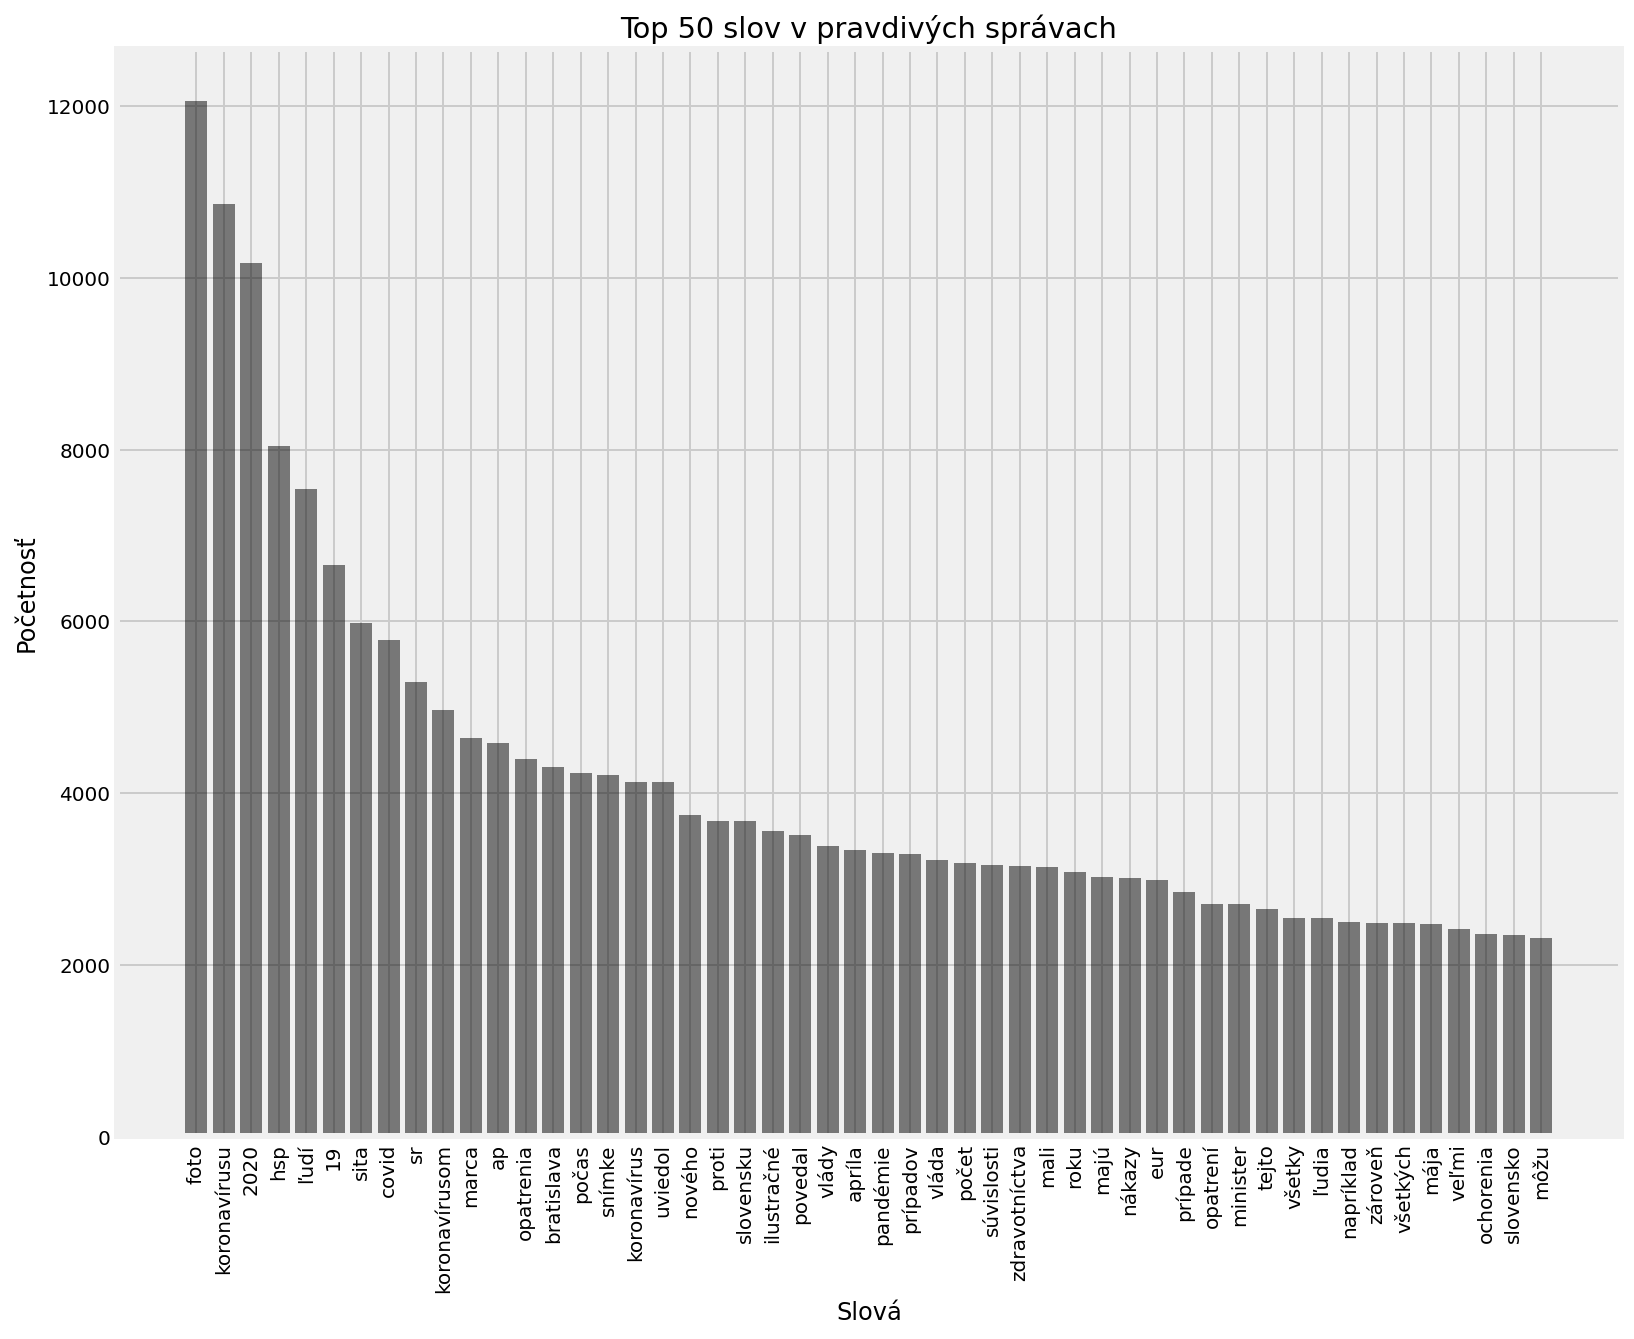

In [21]:
#graf TOP 50 slov vyskytujúcich sa v pravdivých správach
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5,color=["black"])
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Početnosť')
plt.xlabel('Slová')
plt.title('Top 50 slov v pravdivých správach')

Text(0.5, 1.0, 'Top 50 slov vo falošných správach')

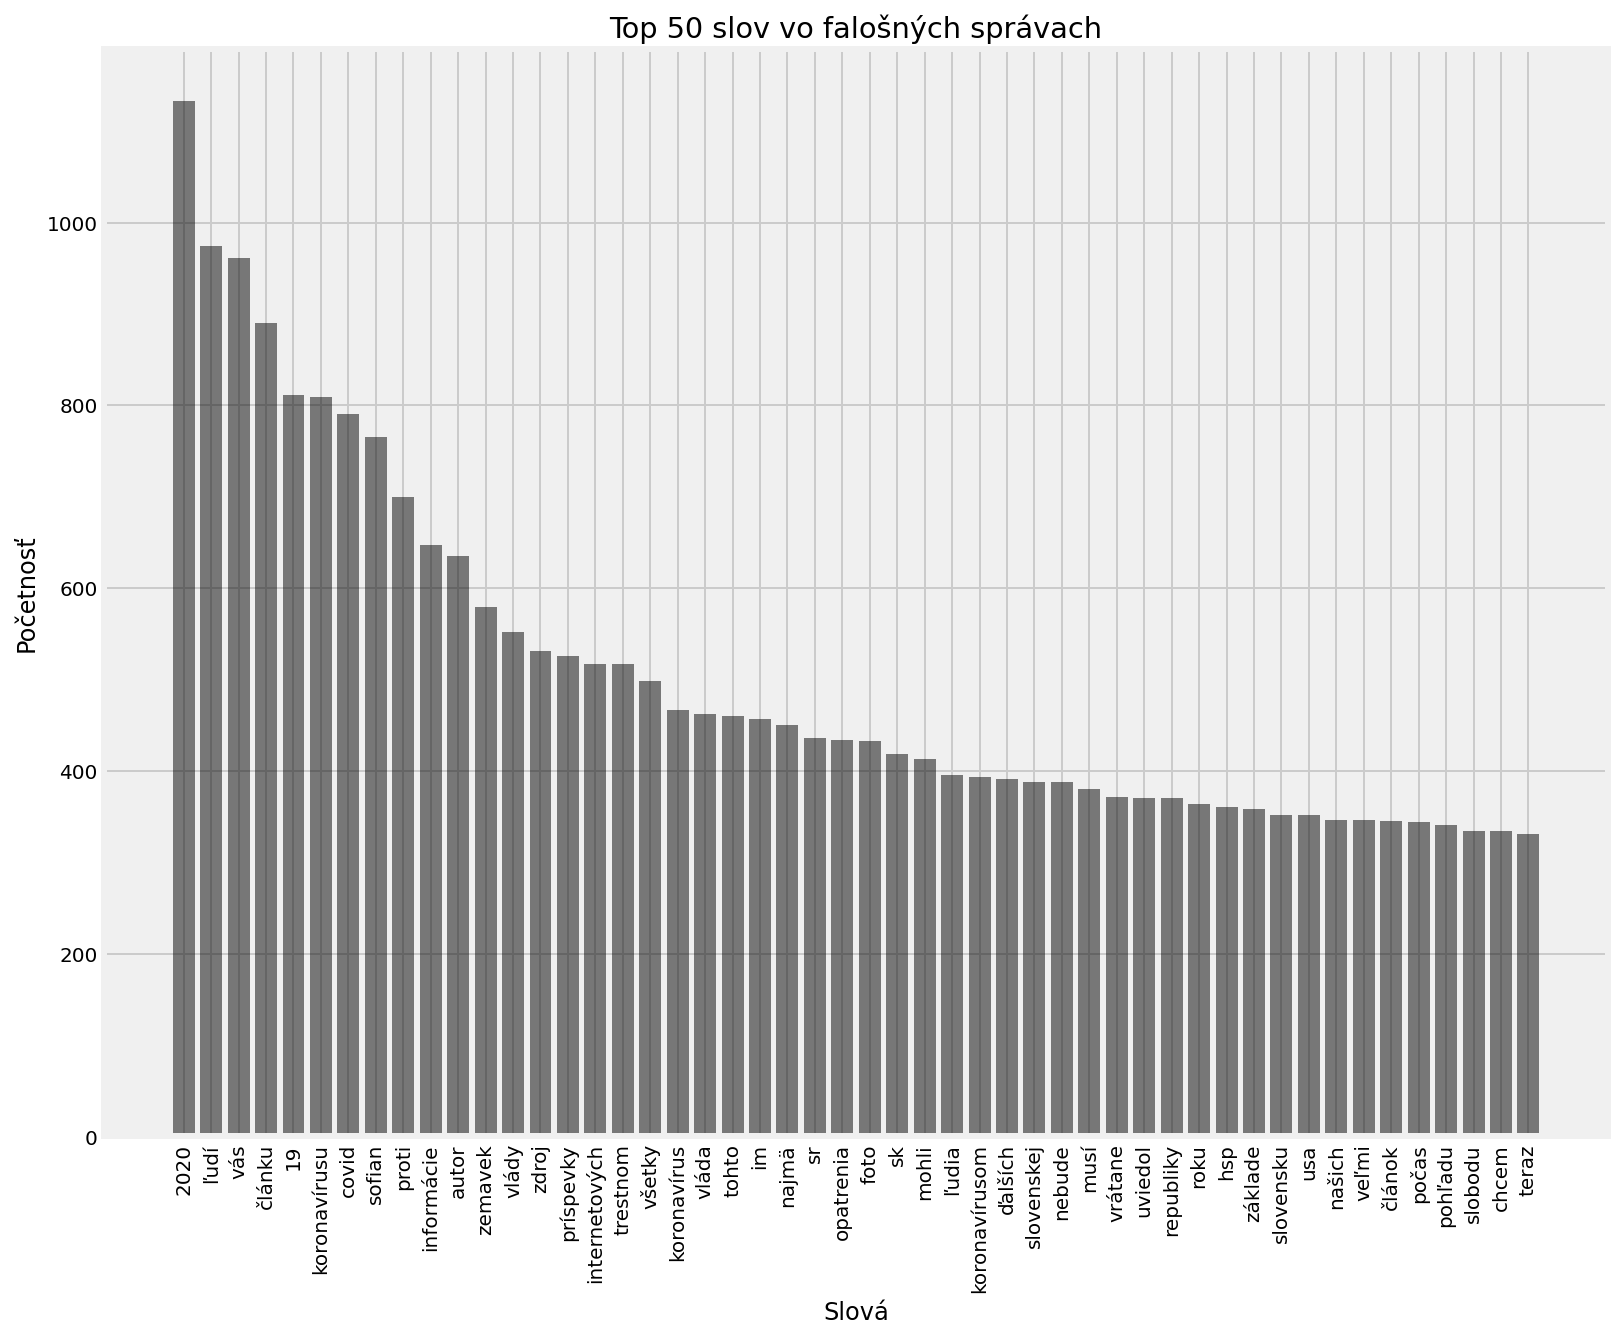

In [22]:
##graf TOP 50 slov vyskytujúcich sa vo falošných správach
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5,color=["black"])
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Početnosť')
plt.xlabel('Slová')
plt.title('Top 50 slov vo falošných správach')

#### V príprave dát do podoby vhodnej pre modelovanie musíme texty článkov vyčistiť a to vymazať interpunkčné znamienka, odkazy na internetové stránky, odkazy obrázkov, odkazy zdrojov, ponechať iba písmená abecedy a zjednotiť text na malé písmená.

In [23]:
#definovanie, čo sa má z textu odstrániť
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+' #odstránenie @
pat2 = r'https?://[^ ]+' #odstránenie odkazov https
combined_pat = r'|'.join((pat1, pat2)) #kombinovane odstránenie pat1 aj pat2
www_pat = r'www.[^ ]+' #odstránenie odkazov www
pat3=r'http?://[^ ]+' #odstránenie odkazov http
combined_pat2 = r'|'.join((www_pat, pat3)) 

pat4=r'img src=[^ ]+' #odstránenie odkazu na obrázok
pat5=r'\(SITA/[^)]*\)' #odstránenie konkrétneho odkazu začínajúceho sa zdrojom SITA
combined_pat3= r'|'.join((pat4, pat5)) 
pat6=r'\(HSP/[^)]*\)' #odstránenie konkrétneho odkazu začínajúceho sa zdrojom HSP
pat7=r'\(TASR/[^)]*\)' #odstránenie konkrétneho odkazu začínajúceho sa zdrojom TASR
combined_pat4= r'|'.join((pat6, pat7)) 

In [24]:
def cleaner(text):
    soup = BeautifulSoup(text, 'lxml') #dekódovanie html na všeobecný text
    souped = soup.get_text()
    try:
        bom_removed = souped.replace("ï¿½", "?") #ošetrenie chyby keď nedekóduje dobre
    except:
        bom_removed = souped
    stripped3 = re.sub(combined_pat, '', bom_removed)
    stripped2= re.sub(combined_pat2, '', stripped3)
    stripped1 = re.sub(combined_pat3, '', stripped2)
    stripped = re.sub(combined_pat4, '', stripped1)
    lower_case = stripped.lower()
    letters_only = re.sub("[^a-zA-Z\ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ]", " ", lower_case)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [25]:
#čistenie textu na trénovacej a testovacej množine
testing_train = x_train.body[0:(len(x_train))]
test_result_train = []
for t in testing_train:
    test_result_train.append(cleaner(t))


testing_test = x_test.body[0:(len(x_test))]
test_result_test = []
for t in testing_test:
    test_result_test.append(cleaner(t))

In [26]:
#vytvorenie dataframe clean_df
clean_train = pd.DataFrame(test_result_train,columns=['body'])
clean_train['label'] = x_train.label #pridanie stĺpca label

clean_test = pd.DataFrame(test_result_test,columns=['body'])
clean_test['label'] = x_test.label 

In [27]:
#uloženie vyčisteného textu
clean_train.to_csv('clean_train_korona_nebalansbezstop.csv',encoding='utf-8')
csv_train = 'clean_train_korona_nebalansbezstop.csv'
df_train = pd.read_csv(csv_train,index_col=0)

clean_test.to_csv('clean_test_korona.csv',encoding='utf-8')
csv_test = 'clean_test_korona.csv'
df_test = pd.read_csv(csv_test,index_col=0)

#### Po vyčístení textu vymažeme potencionálne prázdne hodnoty, kde sa po definovaní kritérií vyčistenia mohlo stať, že bežný text v bunke nezostal. 

In [28]:
df_train.dropna(inplace=True) #vymazanie prázdnych hodnôt
df_train.reset_index(drop=True,inplace=True)

df_test.dropna(inplace=True) #vymazanie prázdnych hodnôt
df_test.reset_index(drop=True,inplace=True)

In [29]:
#ukážka vyčistenej dátovej množiny
df_train.head()

,body,label
0,zatiaľ čo európu paralyzuje koronavírus stále ...,0
1,čím je človek odolnejší so silnejšou imunitou ...,0
2,bratislava júna počet prípadov partnerského ná...,0
3,chorvátsku sa výrazne znížil denný nárast ľudí...,0
4,praha mája predseda hnutia trikolora václav kl...,0


In [30]:
df_train.label.value_counts()

0    8984
1     631
Name: label, dtype: int64

In [31]:
df_test.label.value_counts()

0    3901
1     220
Name: label, dtype: int64

#### Po vyčistení textu pokračujeme vytvorením tokenov z príslušných slov z textu a ich následným prevodom do vektorovej reprezentácie slov tzv. word embeddings. Na vytvorenie word embeddings použijeme nástroj Word2Vec, ktorý je implementovaný pomocou knižnice Gensim, kde výstupom bude množina vektorov. Pripravené vektory prevedieme na tokenizované a ich dĺžky zarovnáme na rovnaké doplnením nulových indexov.

In [32]:
#vytvorenie tokenom zo slov pre trénovaciu a testovaciu množinu
df_token_train = df_train['body'].values.tolist()

token_train=list()
for i in df_token_train:
    word_train=nltk.word_tokenize(i)
    word_train = [w for w in word_train if not w in stop_words]
    token_train.append(word_train)


df_token_test = df_test['body'].values.tolist()

token_test=list()
for i in df_token_test:
    word_test=nltk.word_tokenize(i)
    word_test = [w for w in word_test if not w in stop_words]
    token_test.append(word_test)

In [33]:
#word embeddings pomocou Word2Vec
model = Word2Vec(token_train, min_count = 1)
vocabulary = model.wv.vocab

name = 'w2v.txt'
model.wv.save_word2vec_format(name, binary = False)

embeddings_index = {}
f = open(os.path.join('','w2v.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word_train = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word_train] = coefs
f.close()

In [34]:
max_length = 3700

tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_train)

seq_train = tokenizer.texts_to_sequences(token_train)
seq_test = tokenizer.texts_to_sequences(token_test)

word_index = tokenizer.word_index
print('Najdenych %s jedinecnych tokenov.' %len (word_index))

train_padding = pad_sequences(seq_train, max_length)
test_padding = pad_sequences(seq_test, max_length)

Najdenych 118919 jedinecnych tokenov.


In [35]:
EMBEDDING_DIM = 100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word_train, ii in word_index.items():
    if ii > num_words:
        continue
    embedding_vector = embeddings_index.get(word_train)
    if embedding_vector is not None:
        embedding_matrix[ii] = embedding_vector

In [36]:
y_train = df_train['label'].values
y_test = df_test['label'].values

#### Po pochopení dát a príprave dát prejdeme do fázy modelovania, kde vytvoríme dokopy 3 modely, ktoré vyhodnodnotíme pomocou kontingenčných tabuliek, úspešnosti, návratnosti, F1 skóre...

#### Prvý model je model neurónovej siete s konvolučnou vrstvou, s ReLu a Sigmoid aktivačnou funkciou a optimalizátorom Adam.

In [37]:
#architektúra CNN modelu
inputs = Input(shape=(max_length,))
x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model_cnn = Model(inputs=inputs, outputs=output)
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model_cnn.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3700)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 3700, 100)         11892000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3699, 100)         20100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 11,938,213
Trainable params: 11,938,213
Non-trainable params: 0
_______________________________________________

In [ ]:
#uloženie modelu
saved_model = "model_cnn_korona_bezstop.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
#trénovanie modelu
history = model_cnn.fit(train_padding, y_train, epochs=5, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

In [ ]:
#načítanie modelu
model_cnn=load_model('model_cnn_korona_bezstop.hdf5')

#predikcia na testovacích dátach pomocou natrénovaného modelu,
#vypísanie kontingenčnej tabuľky a metrík na vyhodnotenie ako úspešnosť, návrtanosť, F1 ...
y_cnn = model_cnn.predict(test_padding)
print('Roc auc score is {}'.format(roc_auc_score(y_test, y_cnn)))
y_int = np.zeros_like(y_cnn)
y_int[y_cnn > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

|              | Precision | Recall | F1-score | Support |
|:------------:|:---------:|:------:|:--------:|:-------:|
|       0      |    0.98   |  1.00  |   0.99   |   3901  |
|       1      |    0.98   |  0.62  |   0.76   |   220   |
|              |           |        |          |         |
|   Accuracy   |           |        |   0.98   |   4121  |
|   Macro avg  |    0.98   |  0.81  |   0.88   |   4121  |
| Weighted avg |    0.98   |  0.98  |   0.98   |   4121  |

Accuracy : 0.956238

ROC : 0.979131

| Actual/Predicted | Fake news | True news |
|------------------|-----------|-----------|
| Fake news        |   TP-137  |   FN-83   |
| True news        |   FP-3  |  TN-3898  |

#### Druhý model je model neurónovej siete s rekurentnou LSTM vrstvou, s ReLu a Sigmoid aktivačnou funkciou a optimalizátorom Adam.

In [38]:
#architektúra LSTM modelu
inputs = Input(shape=(max_length,))
x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model_lstm = Model(inputs=inputs, outputs=output)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model_lstm.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3700)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 3700, 100)         11892000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 12,025,889
Trainable params: 12,025,889
Non-trainable params: 0
_______________________________________________

In [ ]:
#uloženie modelu
saved_model = "model_lstm_korona_bezstop.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
#trénovanie modelu
history = model_lstm.fit(train_padding, y_train, epochs=5, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

In [ ]:
#načítanie modelu
model_lstm=load_model('model_lstm_korona_bezstop.hdf5')

#predikcia na testovacích dátach pomocou natrénovaného modelu,
#vypísanie kontingenčnej tabuľky a metrík na vyhodnotenie ako úspešnosť, návrtanosť, F1 ...
y_cnn = model_lstm.predict(test_padding)
print('Roc auc score is {}'.format(roc_auc_score(y_test, y_cnn)))
y_int = np.zeros_like(y_cnn)
y_int[y_cnn > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

|              | Precision | Recall | F1-score | Support |
|:------------:|:---------:|:------:|:--------:|:-------:|
|       0      |    0.99   |  1.00  |   0.99   |   3901  |
|       1      |    0.96   |  0.78  |   0.86   |   220   |
|              |           |        |          |         |
|   Accuracy   |           |        |   0.99   |   4121  |
|   Macro avg  |    0.97   |  0.89  |   0.93   |   4121  |
| Weighted avg |    0.99   |  0.99  |   0.99   |   4121  |

Accuracy : 0.986654

ROC : 0.948821

| Actual/Predicted | Fake news | True news |
|------------------|-----------|-----------|
| Fake news        |   TP-172  |   FN-48   |
| True news        |   FP-7  |  TN-3894  |

#### Tretí model je model neurónovej siete s obojstrannou rekurentnou LSTM vrstvou a konvolučnou vrstvou, s ReLu a Sigmoid aktivačnou funkciou a optimalizátorom Adam.

In [39]:
#architektúra Bi-LSTM + CNN modelu
inputs = Input(shape=(max_length,))
x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(32, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
model_bilstm = Model(inputs=inputs, outputs=output)
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model_bilstm.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3700)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 3700, 100)         11892000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 3700, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 3700, 128)         84480     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3698, 32)          12320     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112

In [ ]:
#uloženie modelu
saved_model = "model_bilstm_korona_bezstop.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
#trénovanie modelu
history = model_bilstm.fit(train_padding, y_train, epochs=5, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

In [ ]:
#načítanie modelu
model_bilstm=load_model('model_bilstm_korona_bezstop.hdf5')

#predikcia na testovacích dátach pomocou natrénovaného modelu,
#vypísanie kontingenčnej tabuľky a metrík na vyhodnotenie ako úspešnosť, návrtanosť, F1 ...
y_cnn = model_bilstm.predict(test_padding)
print('Roc auc score is {}'.format(roc_auc_score(y_test, y_cnn)))
y_int = np.zeros_like(y_cnn)
y_int[y_cnn > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

|              | Precision | Recall | F1-score | Support |
|:------------:|:---------:|:------:|:--------:|:-------:|
|       0      |    0.99   |  1.00  |   0.99   |   3901  |
|       1      |    0.97   |  0.79  |   0.87   |   220   |
|              |           |        |          |         |
|   Accuracy   |           |        |   0.99   |   4121  |
|   Macro avg  |    0.98   |  0.89  |   0.93   |   4121  |
| Weighted avg |    0.99   |  0.99  |   0.99   |   4121  |

Accuracy : 0.987624

ROC : 0.973588

| Actual/Predicted | Fake news | True news |
|------------------|-----------|-----------|
| Fake news        |   TP-174  |   FN-46   |
| True news        |   FP-5  |  TN-3896  |

#### Pre model, ktorého úspešnosť bola najvyššia vykonáme optimalizáciu hyperparametrov prostredníctvom metódy Grid search. Definujeme súbor parametrov, pre ktoré bude Grid search vykonávať kombinácie možností. 

In [ ]:
#definovanie modelu Bi-LSTM + CNN pre optimalizáciu hyperparametrov pomocou Grid search
def bilstm_model(dropout_rate=0.2, activation='relu',optimizer='adam'):
    inputs = Input(shape=(max_length,))
    x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
    x = SpatialDropout1D(dropout_rate)(x)
    x = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
    x = Conv1D(32, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [ ]:
model=KerasClassifier(build_fn=bilstm_model, epochs=5)

import sys
class Tee(object):
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush() 
    def flush(self) :
        for f in self.files:
            f.flush()

In [ ]:
#definovanie parametrov pre Grid search 
dropout_rate = [0.1, 0.2]
batch_size = [16, 32]
optimizer = ['SGD','Adam']
f = open('out_korona.txt', 'w')
original = sys.stdout
sys.stdout = Tee(sys.stdout, f)

In [ ]:
param_grid = dict(batch_size=batch_size, dropout_rate=dropout_rate, optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)

In [ ]:
#trénovanie optimalizácie Grid search
grid_result = grid.fit(train_padding, y_train, verbose=2)

#výsledky po Grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means_acc = grid_result.cv_results_['mean_test_score']
stds_acc = grid_result.cv_results_['std_test_score']
params_acc = grid_result.cv_results_['params']

for  means_acc, stds_acc, params_acc in zip(means_acc, stds_acc, params_acc):
    print("%f (%f) with: %r" % (means_acc, stds_acc, params_acc))

Best: 0.975661 using {'batch_size': 32, 'dropout_rate': 0.1, 'optimizer': 'Adam'}<br/>
0.948199 (0.007708) with: {'batch_size': 16, 'dropout_rate': 0.1, 'optimizer': 'SGD'}<br/>
0.975453 (0.000411) with: {'batch_size': 16, 'dropout_rate': 0.1, 'optimizer': 'Adam'}<br/>
0.948826 (0.008727) with: {'batch_size': 16, 'dropout_rate': 0.2, 'optimizer': 'SGD'}<br/>
0.974621 (0.000827) with: {'batch_size': 16, 'dropout_rate': 0.2, 'optimizer': 'Adam'}<br/>
0.934470 (0.001886) with: {'batch_size': 32, 'dropout_rate': 0.1, 'optimizer': 'SGD'}<br/>
0.975661 (0.001867) with: {'batch_size': 32, 'dropout_rate': 0.1, 'optimizer': 'Adam'}<br/>
0.934470 (0.001886) with: {'batch_size': 32, 'dropout_rate': 0.2, 'optimizer': 'SGD'}<br/>
0.973373 (0.002491) with: {'batch_size': 32, 'dropout_rate': 0.2, 'optimizer': 'Adam'}<br/>

#### Najlepšia kombinácia parametrov pri Grid search vyšla pri dropout_rate odlišná, ako pri modelovaní, ktoré bolo vykonané vyššie. Preto ideme následne model pretrénovať a dropout rate nastavíme z pôvodného 0.2 na 0.1.

In [ ]:
inputs = Input(shape=(max_length,))
x = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = SpatialDropout1D(0.1)(x)
x = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(32, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

In [ ]:
saved_model = "model_bilstm_korona_01.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(train_padding, y_train, epochs=5, batch_size=32, validation_split=0.1, callbacks=[checkpoint])

In [ ]:
model=load_model('model_bilstm_korona_01.hdf5')

y_cnn = model.predict(test_padding)
print('Roc auc score is {}'.format(roc_auc_score(y_test, y_cnn)))
y_int = np.zeros_like(y_cnn)
y_int[y_cnn > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))

In [ ]:
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

|              | Precision | Recall | F1-score | Support |
|:------------:|:---------:|:------:|:--------:|:-------:|
|       0      |    0.99   |  1.00  |   0.99   |   3901  |
|       1      |    0.95   |  0.85  |   0.89   |   220   |
|              |           |        |          |         |
|   Accuracy   |           |        |   0.99   |   4121  |
|   Macro avg  |    0.97   |  0.92  |   0.94   |   4121  |
| Weighted avg |    0.99   |  0.99  |   0.99   |   4121  |

Accuracy : 0.989323

ROC : 0.969314

| Actual/Predicted | Fake news | True news |
|------------------|-----------|-----------|
| Fake news        |   TP-186  |   FN-34   |
| True news        |   FP-10  |  TN-3891  |